# 0. About

This notebook is to check out the usage of the Gaussian process regression, with the scikit-learn.

In [69]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import cross_validate
import scipy
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
import os
import time

# 1. Loading Data

In [9]:
# find where the data is stored
repo_path = os.path.dirname(os.getcwd())
data_path = repo_path + '\\data\\GP_regression\\'

In [11]:
# import data
one_feature_data_arr = np.genfromtxt(data_path+"generated_one_feature_data.csv", delimiter=',')
one_feature_data = {
    "data_num": one_feature_data_arr.shape[0], 
    "x_train": one_feature_data_arr[:, 0].reshape(-1, 1), 
    "y_train": one_feature_data_arr[:, 1].reshape(-1, 1), 
    "std_y_train": one_feature_data_arr[:, 2].flatten()
}


two_feature_data_arr = np.genfromtxt(data_path+"generated_two_feature_data.csv", delimiter=',')
two_feature_data = {
    "data_num": two_feature_data_arr.shape[0], 
    "x_train": two_feature_data_arr[:, :2], 
    "y_train": two_feature_data_arr[:, 2].reshape(-1, 1), 
    "std_y_train": two_feature_data_arr[:, 3].flatten()
}

# 2. One-Feature Training and Regression

## 2.1. Training

In [20]:
# training
kernel = ConstantKernel(constant_value=1)*RBF(length_scale=1.0)
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, 
    alpha=np.power(one_feature_data['std_y_train'], 2), 
    n_restarts_optimizer=9, 
    random_state=42
)
gaussian_process.fit(one_feature_data['x_train'], one_feature_data['y_train']);

In [21]:
print("The optimized kernel is like: ")
print(gaussian_process.kernel_)

The optimized kernel is like: 
58.7**2 * RBF(length_scale=6.48)


## 2.2. Regression/Prediction

In [22]:
# regression/prediction
predict_point_num = 51
x_predict = np.linspace(-1.0, 6.0, predict_point_num).reshape(-1, 1)
y_predict, std_y_predict = gaussian_process.predict(x_predict, return_std=True)
y_predict = y_predict.flatten()

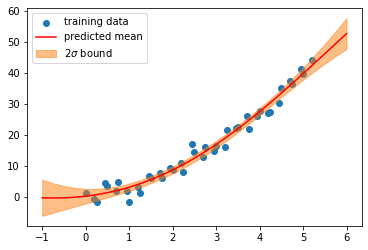

In [23]:
plt.scatter(one_feature_data['x_train'], one_feature_data['y_train'], label='training data')
plt.plot(x_predict, y_predict, color='red', label='predicted mean')
plt.fill_between(
    x_predict.ravel(),
    y_predict-2*std_y_predict,
    y_predict+2*std_y_predict,
    color="tab:orange",
    alpha=0.5,
    label=r"2$\sigma$ bound",
)
plt.legend();

## 2.3. Cross-Validation and R2 Score

In [46]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, 
    alpha=one_feature_data['std_y_train'][0]**2, 
    n_restarts_optimizer=9, 
    random_state=42
)

gpr_scores = cross_validate(
    gaussian_process, one_feature_data['x_train'], 
    one_feature_data['y_train'], cv=5
)

In [47]:
print(gpr_scores['test_score'])

[0.44846945 0.89190694 0.99203948 0.55543938 0.90327777]


# 3. Two-Feature Training and Regression

## 3.1. Training

In [49]:
var_y_train = np.power(two_feature_data['std_y_train'], 2)

kernel = ConstantKernel(constant_value=1)*RBF(length_scale=np.array([0.1, 0.1]))
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, 
    alpha=var_y_train, 
    n_restarts_optimizer=15
)
gaussian_process.fit(two_feature_data['x_train'], two_feature_data['y_train']);

In [50]:
print("The optimized kernel is like: ")
print(gaussian_process.kernel_)

The optimized kernel is like: 
1.53**2 * RBF(length_scale=[2.22, 1.82])


## 3.2. Regression/Prediction

In [51]:
# construct meshgrids
predict_point_num_one_side = 21
predict_one_side_arr = np.linspace(-1.2, 1.2, predict_point_num_one_side)
x_predict_mesh_x, x_predict_mesh_y = np.meshgrid(predict_one_side_arr, predict_one_side_arr)

# prepare the data
x_predict = np.zeros((x_predict_mesh_x.size, 2))
x_predict[:, 0] = x_predict_mesh_x.flatten()
x_predict[:, 1] = x_predict_mesh_y.flatten()

y_predict, std_y_predict = gaussian_process.predict(x_predict, return_std=True)
y_predict_mesh = y_predict.reshape(predict_point_num_one_side, predict_point_num_one_side)
std_y_predict_mesh = std_y_predict.reshape(predict_point_num_one_side, predict_point_num_one_side)
two_sigma_ub_mesh = y_predict_mesh + 2.0*std_y_predict_mesh
two_sigma_lb_mesh = y_predict_mesh - 2.0*std_y_predict_mesh

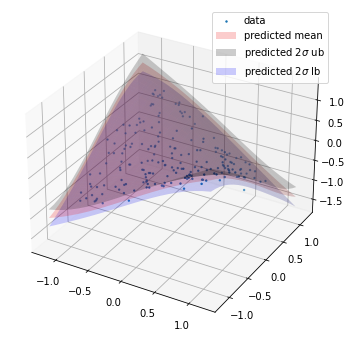

In [58]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(two_feature_data['x_train'][:, 0], 
           two_feature_data['x_train'][:, 1], 
           two_feature_data['y_train'], s=2, label='data')
surf = ax.plot_surface(x_predict_mesh_x, 
                       x_predict_mesh_y, 
                       y_predict_mesh, label='predicted mean', alpha=0.2, color='red')
surf._edgecolors2d = surf._edgecolor3d
surf._facecolors2d = surf._facecolor3d

surf = ax.plot_surface(x_predict_mesh_x, 
                       x_predict_mesh_y, 
                       two_sigma_ub_mesh, label='predicted 2$\sigma$ ub', alpha=0.2, color='black')
surf._edgecolors2d = surf._edgecolor3d
surf._facecolors2d = surf._facecolor3d

surf = ax.plot_surface(x_predict_mesh_x, 
                       x_predict_mesh_y, 
                       two_sigma_lb_mesh, label='predicted 2$\sigma$ lb', alpha=0.2, color='blue')
surf._edgecolors2d = surf._edgecolor3d
surf._facecolors2d = surf._facecolor3d

ax.legend();

## 3.3. Cross-Validation and R2 Score

In [61]:
kernel = ConstantKernel(constant_value=1)*RBF(length_scale=np.array([0.1, 0.1]))
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, 
    alpha=var_y_train[0]**2, 
    n_restarts_optimizer=15
)

gpr_scores = cross_validate(
    gaussian_process, two_feature_data['x_train'], 
    two_feature_data['y_train'], cv=5
)

In [63]:
print(gpr_scores['test_score'])

[0.59025281 0.6255061  0.66324293 0.63044097 0.67466682]


# 4. Modify Max_Iter of the Optimizer

## 4.1. Inheriting from GPR Class

In [70]:
"""
Ref: 
1. For inherit the GPR class:
    https://stackoverflow.com/questions/62376164/how-to-change-max-iter-in-optimize-function-used-by-sklearn-gaussian-process-reg
2. For modifiying the __init__:
    https://stackoverflow.com/questions/40025406/inherit-from-scikit-learns-lassocv-model
"""

class MyGPR(GaussianProcessRegressor):
    def __init__(self, *, kernel=None, alpha=1e-10, optimizer="fmin_l_bfgs_b", 
                 n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, 
                 random_state=None, max_iter=2e05, ):
        self.max_iter = max_iter
        super().__init__(kernel=kernel, alpha=alpha, optimizer=optimizer, 
                         n_restarts_optimizer=n_restarts_optimizer, 
                         normalize_y=normalize_y, 
                         copy_X_train=copy_X_train, random_state=random_state)

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, 
                                              method="L-BFGS-B", jac=True, 
                                              bounds=bounds, 
                                              options={'maxiter': self.max_iter})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

## 4.2. Training

In [72]:
kernel = ConstantKernel(constant_value=1)*RBF(length_scale=1.0)
gaussian_process = MyGPR(
    max_iter=1e5, 
    kernel=kernel, 
    alpha=one_feature_data['std_y_train'][0]**2, 
    n_restarts_optimizer=9, 
    random_state=42
)
gaussian_process.fit(one_feature_data['x_train'], one_feature_data['y_train']);